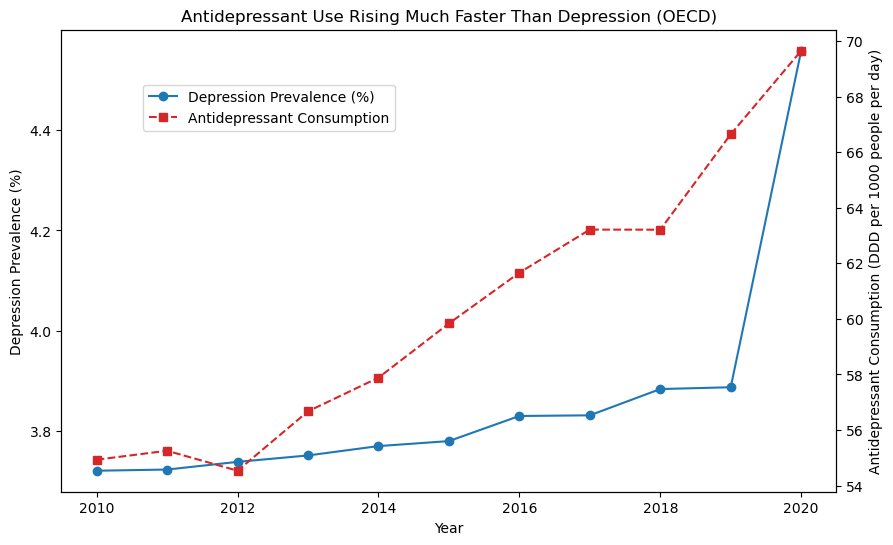

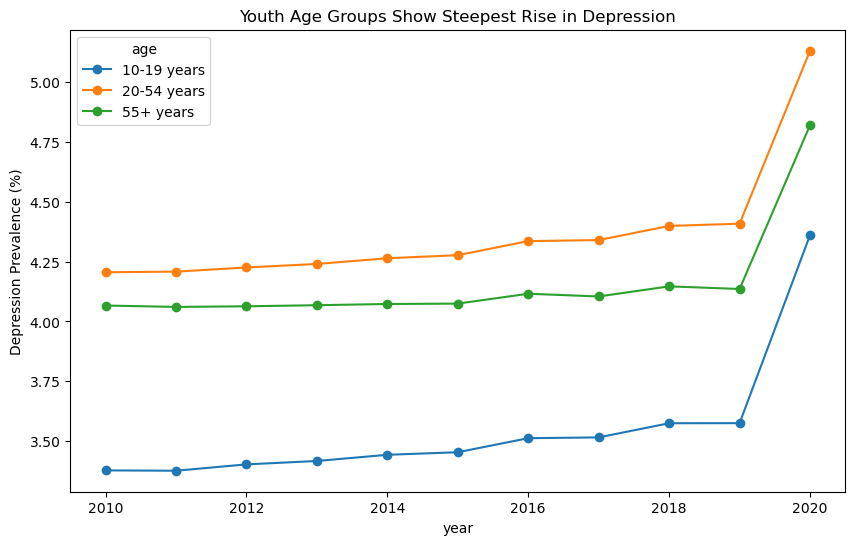

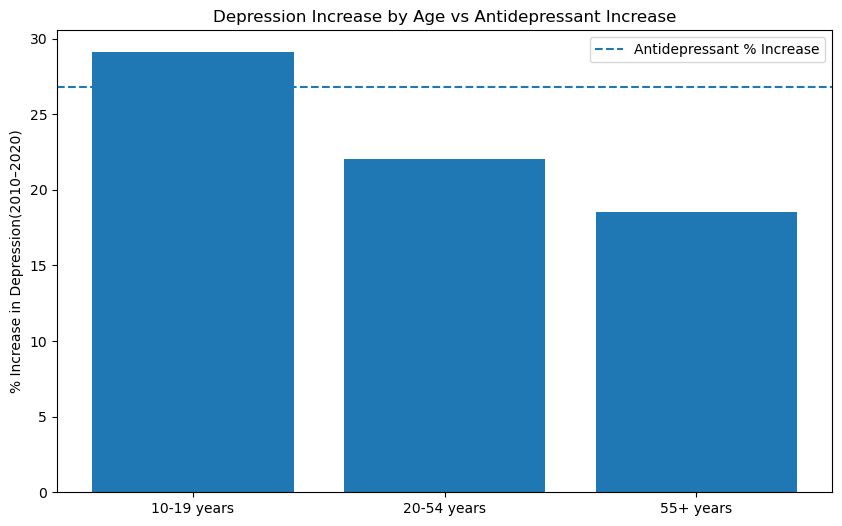

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


BASE_DIR = Path().resolve()          
DATA_DIR = BASE_DIR / "Datasets"    

anti = pd.read_csv(DATA_DIR / "antidepressants-per-capita.csv")
dep = pd.read_csv(DATA_DIR / "IHME-GBD_2023_DATA-db1170a7-1.csv")


# -----------------------------
# FIX COUNTRY NAME MISMATCHES
# -----------------------------
dep['location'] = dep['location'].replace({
    'United States of America': 'United States',
    'Czech Republic': 'Czechia',
    'Russian Federation': 'Russia'
})

# -----------------------------
# FILTER YEARS
# -----------------------------
anti = anti[(anti['Year'] >= 2010) & (anti['Year'] <= 2020)]

dep = dep[
    (dep['measure'] == 'Prevalence') &
    (dep['metric'] == 'Percent') &
    (dep['sex'] == 'Both') &
    (dep['cause'] == 'Depressive disorders') &
    (dep['year'].between(2010, 2020))
]

# Convert to %
dep['val'] = dep['val'] * 100

# -----------------------------
# KEEP MATCHING COUNTRIES
# -----------------------------
common = set(anti['Entity']).intersection(set(dep['location']))
anti = anti[anti['Entity'].isin(common)]
dep = dep[dep['location'].isin(common)]

# -----------------------------
# SPLIT DATA
# -----------------------------
dep_all = dep[dep['age'] == 'All ages']
dep_age = dep[dep['age'] != 'All ages']

# -----------------------------
# PLOT 1 — MACRO
# -----------------------------

dep_year = dep_all.groupby('year')['val'].mean().reset_index()
anti_year = anti.groupby('Year')['Consumption Rate'].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

# Depression axis 
ax1.plot(dep_year['year'], dep_year['val'],
         linestyle='-', marker='o', color='tab:blue',
         label='Depression Prevalence (%)')

ax1.set_xlabel('Year')
ax1.set_ylabel('Depression Prevalence (%)')
ax1.tick_params(axis='y')
ax1.set_title('Antidepressant Use Rising Much Faster Than Depression (OECD)')

# Antidepressant axis 
ax2 = ax1.twinx()
ax2.plot(anti_year['Year'], anti_year['Consumption Rate'],
         linestyle='--', marker='s', color='tab:red',
         label='Antidepressant Consumption')

ax2.set_ylabel('Antidepressant Consumption (DDD per 1000 people per day)')
ax2.tick_params(axis='y')

# Legend
fig.legend(loc='upper left', bbox_to_anchor=(0.2,0.8))

plt.show()

# -----------------------------
# PLOT 2 — MICRO (AGE GROUPS)
# -----------------------------
age_trend = dep_age.groupby(['year','age'])['val'].mean().reset_index()
pivot_age = age_trend.pivot(index='year', columns='age', values='val')

pivot_age.plot(figsize=(10,6), marker='o')
plt.title('Youth Age Groups Show Steepest Rise in Depression')
plt.ylabel('Depression Prevalence (%)')
plt.show()

# -----------------------------
# PLOT 3 — ACTIONABLE
# -----------------------------
# % change antidepressants
anti_change = anti.groupby('Year')['Consumption Rate'].mean().loc[[2010,2020]]
anti_pct = (anti_change.loc[2020] - anti_change.loc[2010]) / anti_change.loc[2010] * 100

# % change by age
start = age_trend[age_trend['year']==2010]
end = age_trend[age_trend['year']==2020]
change = end.merge(start, on='age')
change['pct_increase'] = (change['val_x'] - change['val_y']) / change['val_y'] * 100

plt.figure(figsize=(10,6))
plt.bar(change['age'], change['pct_increase'])
plt.axhline(anti_pct, linestyle='--', label='Antidepressant % Increase')
plt.legend()
plt.title('Depression Increase by Age vs Antidepressant Increase')
plt.ylabel('% Increase in Depression(2010–2020)')
plt.show()
